In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.naive_bayes import MultinomialNB

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
if not os.path.exists('pickle_files'):
    os.mkdir('pickle_files')

### Which Naive Bayes to apply- Bernoulli, Multinomial or Gaussian?
When we only care about a word being present or not in a document, then we use Bernoulli NB, if the frequency of words in a document is of interest and not just if it is present or not, then we use Multinomial NB. Gaussian NB is used when we have continuous real-valued features (values that can take any real values).

For this problem, a given word can take values from a min 0 to a max of (num_of_documents_in_corpus), therefore we should use Multinomial NB.

In [6]:
from sklearn.naive_bayes import MultinomialNB

### Train-test splitter for dataset sorted wrt time

In [7]:
### X and y, before being passed to this function must be converted to numpy array or must be sparse matrices\
### for consistency throughout the program.

### y will be a numpy vector because y-values originally are stored in a column of the original dataframe (ie, it\
### will be of type pd.Series. When converted into np-array, it will become a numpy 1D array, i.e a column vector)

def train_test_splitter(X, y, test_size = 0.2):
    train_size = 1 - test_size
    
    train_row_upper_index = round(train_size*X.shape[0])
    test_row_lower_index = train_row_upper_index + 1
    
    if(X.ndim == 1):
        X = X.reshape((X.shape[0], 1))
    y = y.reshape((y.shape[0], 1)) # y is 
    
    X_train = X[:train_row_upper_index + 1, :]
    X_test = X[test_row_lower_index:, :]
    
    y_train = y[:train_row_upper_index + 1]
    y_test = y[test_row_lower_index:]
    
    return X_train, y_train, X_test, y_test

### Hyperparameter tuning

#### save best NB model
This function can be reused. It can be added to any program to save intermediate best model trained during hyperparameter tuning (although it can save any python object in general).

In [8]:
def save_best_model(model, save_name):

    with open('pickle_files/nb_best_' + save_name + '.pkl', 'wb') as pkl_file:
        pickle.dump(model, pkl_file)

In [9]:
def save_f1_scores_and_y_pred_best(f1scores, y_pred, save_name):
    
    with open('pickle_files/f1scores_' + save_name + '.pkl', 'wb') as pkl_file:
        pickle.dump(f1scores, pkl_file)
        
    with open('pickle_files/y_pred_best_' + save_name + '.pkl', 'wb') as pkl_file:
        pickle.dump(y_pred, pkl_file)

In [10]:
def plot_f1scores_vs_alpha(f1scores, alphas):
    
    plt.plot(alphas, f1scores)
    
    max_f1score = max(f1scores)
    alpha_corr_to_max_f1score = alphas[f1scores.index(max_f1score)]
    
    f1scores.remove(max_f1score)
    alphas.remove(alpha_corr_to_max_f1score)
    plt.title('F1-scores vs alpha')
    plt.xlabel('alpha')
    plt.ylabel('f1scores')
    plt.scatter(alphas, f1scores, c = 'red')
    
    plt.scatter(alpha_corr_to_max_f1score, max_f1score, c = 'yellow', s = 50, edgecolors = 'black', marker = 'D',\
               label = '(' + str(alpha_corr_to_max_f1score) + ', ' + str(max_f1score) + ')')
    
    plt.legend()
    plt.show()

In [11]:
def plot_conf_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix)
    
    sns.heatmap(conf_matrix_df, annot = True)
    plt.show()

#### tune_alpha (laplace smoothing parameter, pseudocount)

In [12]:
def tune_alpha(alphas, X_train, y_train, X_cv, y_cv, save_name):
    
    best_alpha = None
    precisions = []
    recalls = []
    f1scores =[]
    
    f1score_max = 0
    best_alpha = None
    y_pred_best = None
    best_multinomial_nb = None
    
    if os.path.exists('pickle_files/nb_best_' + save_name + '.pkl'):
        with open('pickle_files/nb_best_' + save_name + '.pkl', 'rb') as pkl_file:
            multinomial_nb = pickle.load(pkl_file)
            
        ### if the model was already present, this means the f1scores and y_pred_best also must have been saved as well
        with open('pickle_files/f1scores_' + save_name + '.pkl', 'rb') as pkl_file:
            f1scores = pickle.load(pkl_file)
        
        with open('pickle_files/y_pred_best_' + save_name + '.pkl', 'rb') as pkl_file:
            y_pred_best = pickle.load(pkl_file)
        
        plot_f1scores_vs_alpha(f1scores, alphas)
        plot_conf_matrix(y_cv, y_pred_best)
        
        return multinomial_nb
    
    for alpha in alphas:
        multinomial_nb = MultinomialNB(alpha = alpha, fit_prior = True, class_prior = None)
        multinomial_nb = multinomial_nb.fit(X_train, y_train.ravel())
        
        y_pred = multinomial_nb.predict(X_cv)
        
        precisions.append(precision_score(y_cv, y_pred))
        recalls.append(recall_score(y_cv, y_pred))
        
        f1score = f1_score(y_cv, y_pred)
        f1scores.append(f1score)
        
        if(f1score > f1score_max):
            f1score_max = f1score
            y_pred_best = y_pred ### for building the confusion matrix
            best_alpha = alpha
            
            ### this function will overwrite the previous best model
            best_multinomial_nb = multinomial_nb
            save_best_model(best_multinomial_nb, save_name)
            
    save_f1_scores_and_y_pred_best(f1scores, y_pred_best, save_name)
    plot_f1scores_vs_alpha(f1scores, alphas)
    plot_conf_matrix(y_cv, y_pred_best)
    
    return best_multinomial_nb

### Import dataset

In [13]:
import sqlite3

In [14]:
db_connection = sqlite3.connect('database.sqlite')

In [15]:
df = pd.read_sql_query('select * from reviews where Score != 3', db_connection)

In [16]:
df.shape

(525814, 10)

In [17]:
scores = df['Score']

### Replacing the ratings with 0 (for negative reviews) and 1 (for positive reviews).
 Score of  >3 has been considered as positive and a score of <3 has been taken as negative

In [18]:
scores[:6]

0    5
1    1
2    4
3    2
4    5
5    4
Name: Score, dtype: int64

In [19]:
scores = list(map(lambda x: 0 if x < 3 else 1, scores))

In [20]:
scores[:6]

[1, 0, 1, 0, 1, 1]

In [21]:
df['Score'] = scores

### Data preprocessing

##### 1. Deduplication
If a user id has multiple entries for the same timestamp, then it should be removed because it is likely that multiple entries at the same timestamp were for the same product of different variety which has a different product id than other variants


In [22]:
df.duplicated(subset = ['UserId', 'Time']).sum()

197082

In [23]:
deduplicated_df = df.drop_duplicates(subset = ['UserId', 'Time'], inplace = False, keep = 'first')

In [24]:
deduplicated_df.shape

(328732, 10)

#### 2. Taking first 60k rows (only for the purpose of finishing this assignment assignment) after sorting wrt Time

In [25]:
df = deduplicated_df.sort_values(by = 'Time')

In [26]:
df = df.iloc[:100000, :]

In [27]:
scores = df['Score']

#### 3. Extracting the data needed (corpus) and removing html and punctuations

In [28]:
corpus = df['Text']

In [29]:
# dataset cleaners

import re

def remove_html(sentence):
    html_tag_re_obj = re.compile('<.*>?')
    sentence = re.sub(html_tag_re_obj, ' ', sentence)
#     amps_re = re.compile('&.+')
#     sentence = re.sub(amps_re, ' ', sentence)
    return sentence

def remove_punctuations(sentence):
    cleaned_sentence = re.sub(r'[^a-zA-Z]', r' ', sentence)
    return cleaned_sentence

In [30]:
cleaned_corpus = []
for doc in corpus:
    cleaned_doc_1 = remove_html(doc)
    cleaned_doc_2 = remove_punctuations(doc)
    cleaned_corpus.append(cleaned_doc_2)

#### 3. Removing stop words

In [31]:
## Since the negative food reviews are likely to contain words like "don't", "didn't", etc that impart important
## meaning to the review, we check if such words exist in the corpus that we have. If these words are in the corpus,
## then they should not be in the list of stop words that we use for removing the stopwords from our corpus

count = 0
for doc in cleaned_corpus:
    if "not" in doc:
        count += 1

print(count)

count = 0
for doc in cleaned_corpus:
    if "don't" in doc:
        count += 1

print(count)

count = 0
for doc in cleaned_corpus:
    if "didn't" in doc:
        count += 1

print(count)

36065
0
0


Setting the corpus to cleaned_corpus

In [32]:
corpus = cleaned_corpus

In [33]:
from nltk.corpus import stopwords

In [34]:
stopwords = stopwords.words('english')

In [35]:
stopwords = set(stopwords)

In [36]:
stopwords.remove('not')

In [37]:
'not' in stopwords

False

In [38]:
corpus = list(map(lambda doc: doc.lower(), corpus))

In [39]:
corpus[:1]

['this witty little book makes my son laugh at loud  i recite it in the car as we re driving along and he always can sing the refrain  he s learned about whales  india  drooping roses   i love all the new words this book  introduces and the silliness of it all   this is a classic book i am  willing to bet my son will still be able to recite from memory when he is  in college']

In [40]:
### filtered_corpus = corpus with docs having no stop words
### using lambda expression for this

filtered_corpus = list(map(lambda doc: ' '.join(list(filter(lambda word: True if word not in stopwords else False\
                                                            , doc.split()))), corpus))

In [41]:
filtered_corpus[:2]

['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college',
 'remember seeing show aired television years ago child sister later bought lp day thirty something used series books amp songs student teaching preschoolers amp turned whole school purchasing cd along books children amp tradition lives']

#### 4. Stemming the words (SnowballStemmer)

In [42]:
from nltk.stem import SnowballStemmer

In [43]:
stemmer = SnowballStemmer('english')

In [44]:
stemmed_filtered_corpus = list(map(lambda doc: ' '.join(list(map(stemmer.stem, doc.split()))), filtered_corpus))

In [45]:
stemmed_filtered_corpus[:3]

['witti littl book make son laugh loud recit car drive along alway sing refrain learn whale india droop rose love new word book introduc silli classic book will bet son still abl recit memori colleg',
 'rememb see show air televis year ago child sister later bought lp day thirti someth use seri book amp song student teach preschool amp turn whole school purchas cd along book children amp tradit live',
 'beetlejuic well written movi everyth excel act special effect delight chose view movi']

In [46]:
corpus = stemmed_filtered_corpus

### Splitting into train, cv and test sets

In [47]:
type(corpus)

list

In [48]:
### train_test splitter takes only numpy arrays and sparse matrices as arguments
corpus = np.array(corpus)
scores = np.array(scores)

In [49]:
X_train_nought, y_train_nought, X_test, y_test = train_test_splitter(corpus, scores, test_size = 0.2)

In [50]:
X_train, y_train, X_cv, y_cv = train_test_splitter(X_train_nought, y_train_nought, test_size = 0.2)

In [51]:
print('X_train: ' + str(type(X_train)), 'y_train: ' + str(type(y_train)), 'X_cv: '+str(type(X_cv)), \
      'y_cv: ' + str(type(y_cv)))

X_train: <class 'numpy.ndarray'> y_train: <class 'numpy.ndarray'> X_cv: <class 'numpy.ndarray'> y_cv: <class 'numpy.ndarray'>


In [52]:
X_train.shape

(64002, 1)

### 1. Bag of Words (CountVectorizer)
##### Note: Vectorization must be done on training set only, not on test set or the cross validation set!

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
if not os.path.exists('pickle_files/bow_pickles'):
    os.mkdir('pickle_files/bow_pickles')
    
if os.path.exists('pickle_files/bow_pickles/document_term_matrix.pkl'):
    with open('pickle_files/bow_pickles/document_term_matrix.pkl', 'rb') as dtm_pickle:
        X_train_bow = pickle.load(dtm_pickle)
    with open('pickle_files/bow_pickles/count_vectorizer.pkl', 'rb') as vectorizer:
        count_vectorizer = pickle.load(vectorizer)
        
else:
    count_vectorizer = CountVectorizer()
    
#     fit() method takes 1D array (m,). train_test_splitter() returns (m,n) array. ravel() converts it into (m,)
    count_vectorizer = count_vectorizer.fit(X_train.ravel())
    X_train_bow = count_vectorizer.transform(X_train.ravel()) # document_term_matrix is saved as X_train_bow
    with open('pickle_files/bow_pickles/document_term_matrix.pkl', 'wb') as dtm_pickle:
        pickle.dump(X_train_bow, dtm_pickle)
    with open('pickle_files/bow_pickles/count_vectorizer.pkl', 'wb') as vectorizer:
        pickle.dump(count_vectorizer, vectorizer)

In [55]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [56]:
X_train_bow.shape

(64002, 31976)

### 2. TfIdf (TfIdfVectorizer)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
if not os.path.exists('pickle_files/tfidf_pickles'):
    os.mkdir('pickle_files/tfidf_pickles')
    
if os.path.exists('pickle_files/tfidf_pickles/document_term_matrix.pkl'):
    with open('pickle_files/tfidf_pickles/document_term_matrix.pkl', 'rb') as dtm_pickle:
        X_train_tfidf = pickle.load(dtm_pickle)
    with open('pickle_files/tfidf_pickles/tfidf_vectorizer.pkl', 'rb') as vectorizer:
        tfidf_vectorizer = pickle.load(vectorizer)
        
else:
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer = tfidf_vectorizer.fit(X_train.ravel())
    X_train_tfidf = tfidf_vectorizer.transform(X_train.ravel())
    with open('pickle_files/tfidf_pickles/document_term_matrix.pkl', 'wb') as dtm_pickle:
        pickle.dump(X_train_tfidf, dtm_pickle)
    with open('pickle_files/tfidf_pickles/tfidf_vectorizer.pkl', 'wb') as vectorizer:
        pickle.dump(tfidf_vectorizer, vectorizer)

In [59]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [60]:
X_train_tfidf.shape

(64002, 31976)

### Naive Bayes for BoW (CountVectorizer)

In [61]:
X_cv_bow = count_vectorizer.transform(X_cv.ravel())
X_test_bow = count_vectorizer.transform(X_test.ravel())

In [62]:
print(y_train.shape, y_cv.shape)

(64002, 1) (15999, 1)


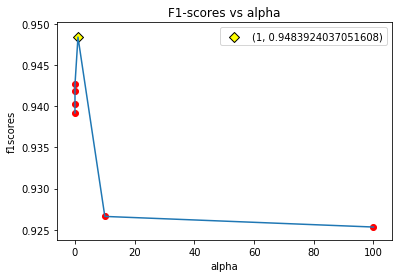

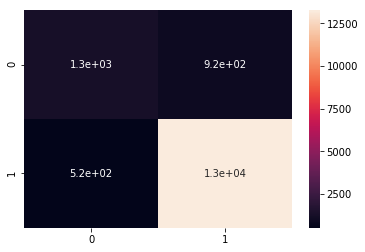

In [63]:
nb_model = tune_alpha(alphas = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100], \
                   X_train = X_train_bow, y_train = y_train, X_cv = X_cv_bow, y_cv = y_cv, save_name = 'bow')

#### Finding TRP, FPR, TNR, FNR

In [64]:
### loading the y_pred predicted by the best alpha value (saved as pickle by tune_alpha() method)
with open('pickle_files/y_pred_best_bow.pkl', 'rb') as pkl_file:
    y_pred_best = pickle.load(pkl_file)

In [65]:
tn, fp, fn, tp = confusion_matrix(y_cv, y_pred_best).ravel()

In [66]:
print(tn, fp, fn, tp)

1297 925 518 13259


In [67]:
tpr = tp/(tp+fn) # true_positive_predicted per acutal_positive
fpr = fp/(tn+fp) # false_positive_predicted per actual_negative
fnr = fn/(tp+fn) # false_negative_prediceted per actual_positive
tnr = tn/(tn+fp) # true_negative_predicted per actual_negative

In [68]:
print('tpr: ' + str(tpr))
print('fpr: ' + str(fpr))
print('fnr: ' + str(fnr))
print('tnr: ' + str(tnr))

tpr: 0.9624011032880888
fpr: 0.4162916291629163
fnr: 0.037598896711911155
tnr: 0.5837083708370837


### Naive Bayes' for Tf-Idf

In [69]:
X_cv_tfidf = tfidf_vectorizer.transform(X_cv.ravel())
X_test_tfidf = tfidf_vectorizer.transform(X_test.ravel())

In [70]:
print(y_train.shape, y_cv.shape)

(64002, 1) (15999, 1)


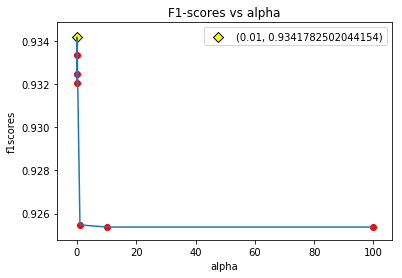

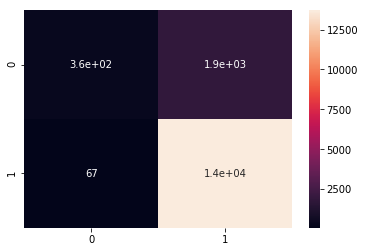

In [71]:
nb_model = tune_alpha(alphas = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100], \
                   X_train = X_train_tfidf, y_train = y_train, X_cv = X_cv_tfidf, y_cv = y_cv, save_name = 'tfidf')

#### Finding TRP, FPR, TNR, FNR

In [72]:
### loading the y_pred predicted by the best alpha value (saved as pickle by tune_alpha() method)
with open('pickle_files/y_pred_best_tfidf.pkl', 'rb') as pkl_file:
    y_pred_best = pickle.load(pkl_file)

In [73]:
tn, fp, fn, tp = confusion_matrix(y_cv, y_pred_best).ravel()

In [74]:
print(tn, fp, fn, tp)

357 1865 67 13710


In [75]:
tpr = tp/(tp+fn) # true_positive_predicted per acutal_positive
fpr = fp/(tn+fp) # false_positive_predicted per actual_negative
fnr = fn/(tp+fn) # false_negative_prediceted per actual_positive
tnr = tn/(tn+fp) # true_negative_predicted per actual_negative

In [76]:
print('tpr: ' + str(tpr))
print('fpr: ' + str(fpr))
print('fnr: ' + str(fnr))
print('tnr: ' + str(tnr))

tpr: 0.9951368222399651
fpr: 0.8393339333933393
fnr: 0.00486317776003484
tnr: 0.16066606660666066
